In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import torchvision as tv

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler


In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_ds():
  img_r_h = 320
  img_r_l = 320
  folder_path = "/content/drive/MyDrive/neiron lab/Latysheva/lab3/img"

  img_list = os.listdir(folder_path)
  dataset=[]
  noise_dataset=[]

  for image_name in img_list:
    image = cv2.imread(folder_path + '/' + image_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_rst = cv2.blur(image, (20, 20))

    image = Image.fromarray(image)
    image = image.resize((img_r_l ,img_r_h))
    image = np.array(image, np.float32)/255

    img_rst = Image.fromarray(img_rst)
    img_rst = img_rst.resize((img_r_l ,img_r_h))
    img_rst = np.array(img_rst, np.float32)/255

    dataset.append(image)
    noise_dataset.append(img_rst)
  return dataset, noise_dataset

In [ ]:
def show_img(dataset):
  fig, axs = plt.subplots(2,4, figsize = (16, 8))
  i = 0
  for j in range(4):
    axs[0][j].imshow(dataset[i])
    i += 1
    axs[1][j].imshow(dataset[i])
    i += 1
  plt.show()

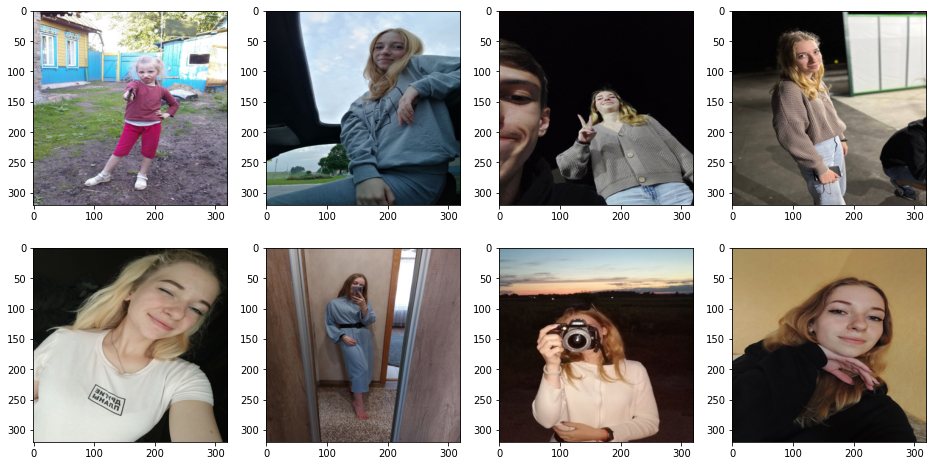

In [ ]:
ds, ds_noise = create_ds()
show_img(ds)

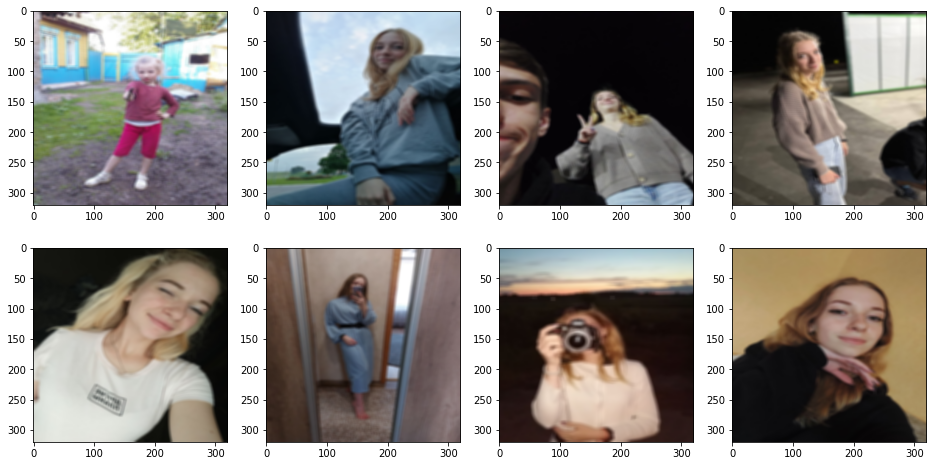

In [ ]:
show_img(ds_noise)

In [ ]:
#поменяла l и h
ds_noise = np.array(ds_noise)

print(ds_noise.shape)

(8, 320, 320, 3)


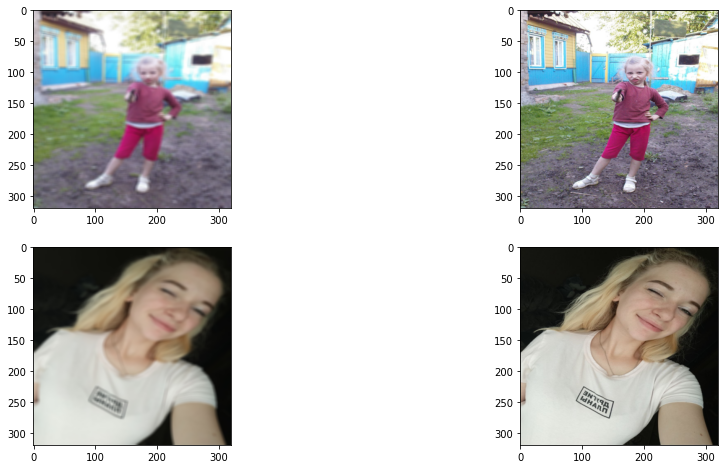

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (16, 8))

axs[0][0].imshow(ds_noise[0])
axs[0][1].imshow(ds[0])
axs[1][0].imshow(ds_noise[1])
axs[1][1].imshow(ds[1])

In [ ]:
import torchvision.transforms as T

preprocess = T.Compose([
   T.ToTensor()])

In [ ]:
def data_to_totch(ds, preprocess):
  data = []
  for img in ds:
    tens = preprocess(img)[:3,:,:].unsqueeze(0)
    tens = tens.type('torch.FloatTensor')
    data.append(tens)
  return np.array(data)

In [ ]:
t_data  = data_to_totch(ds, preprocess)
t_data_noise = data_to_totch(ds_noise, preprocess)

t_ds = []
for i in range(len(t_data)):
  t_ds.append((t_data_noise[i],t_data[i]))

print(t_data[0].shape)

torch.Size([1, 3, 320, 320])


<ipython-input-181-2e392d0937f1>:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data)
<ipython-input-181-2e392d0937f1>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
train_loader = torch.utils.data.DataLoader(t_data_noise[:6], batch_size = 2)

test_loader = torch.utils.data.DataLoader(t_data_noise[6:], batch_size = 2)

In [ ]:
train_loader

In [ ]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):

        super().__init__()

        super(ConvAutoencoder, self).__init__()

        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))

        return x

In [ ]:
# initialize the NN
model = ConvAutoencoder()
model2 = ConvAutoencoder()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
optimizer2 = torch.optim.SGD(model2.parameters(), lr= 0.01)

In [ ]:
def fit(model, criterion, optimizer, train_loader):
  n_epochs = 50
  loss_trn = []

  for epoch in range(1, n_epochs+1):
      train_loss = 0.0

      ###################
      # train the model #
      ###################
      for data ,true_img  in train_loader:
          noise_img = data
          optimizer.zero_grad()
          outputs = model(noise_img)
          loss = criterion(outputs, true_img)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()*true_img.size(0)

      train_loss = train_loss/len(train_loader)
      loss_trn.append(train_loss)
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
  return loss_trn

In [ ]:
loss_trn = fit(model, criterion, optimizer, train_loader)
loss_trn2 = fit(model2, criterion, optimizer2, train_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.084506
Epoch: 2 	Training Loss: 0.079950
Epoch: 3 	Training Loss: 0.082296
Epoch: 4 	Training Loss: 0.078536
Epoch: 5 	Training Loss: 0.078120
Epoch: 6 	Training Loss: 0.077872
Epoch: 7 	Training Loss: 0.077758
Epoch: 8 	Training Loss: 0.077543
Epoch: 9 	Training Loss: 0.077445
Epoch: 10 	Training Loss: 0.077190
Epoch: 11 	Training Loss: 0.077100
Epoch: 12 	Training Loss: 0.077033
Epoch: 13 	Training Loss: 0.076995
Epoch: 14 	Training Loss: 0.076780
Epoch: 15 	Training Loss: 0.076675
Epoch: 16 	Training Loss: 0.076544
Epoch: 17 	Training Loss: 0.076410
Epoch: 18 	Training Loss: 0.076293
Epoch: 19 	Training Loss: 0.076092
Epoch: 20 	Training Loss: 0.076052
Epoch: 21 	Training Loss: 0.075777
Epoch: 22 	Training Loss: 0.075792
Epoch: 23 	Training Loss: 0.075599
Epoch: 24 	Training Loss: 0.075368
Epoch: 25 	Training Loss: 0.075328
Epoch: 26 	Training Loss: 0.075025
Epoch: 27 	Training Loss: 0.075317
Epoch: 28 	Training Loss: 0.074948
Epoch: 29 	Training Loss: 0.0

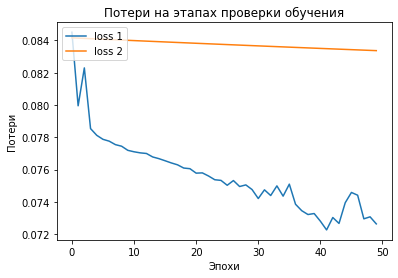

In [ ]:
plt.plot(loss_trn)
plt.plot(loss_trn2)
plt.title('Потери на этапах проверки обучения')
plt.ylabel('Потери')
plt.xlabel('Эпохи')
plt.legend(['loss 1','loss 2'], loc='upper left')
plt.show()

In [ ]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

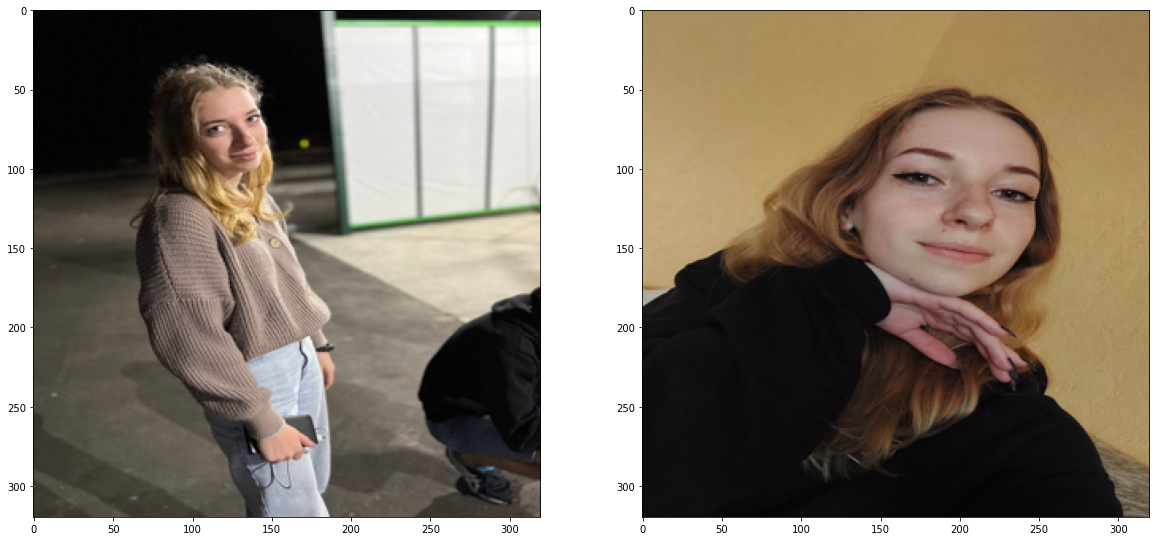

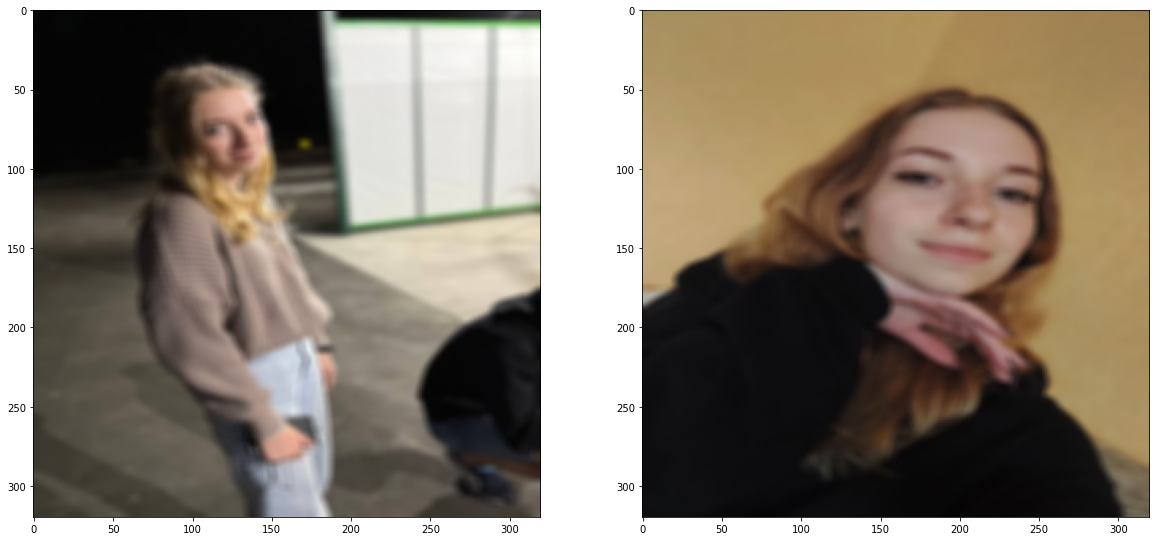

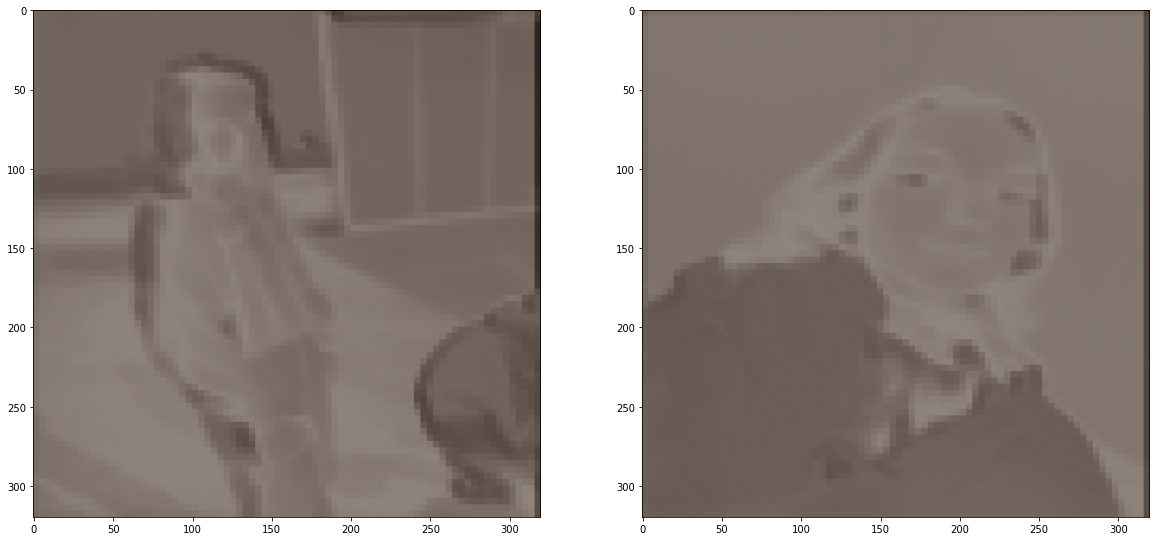

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(t_data[6]))
ax2.imshow(im_convert(t_data[7]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(t_data_noise[6]))
ax2.imshow(im_convert(t_data_noise[7]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(model(t_data_noise[6])))
ax2.imshow(im_convert(model(t_data_noise[7])))